In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import math
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('airbnb.csv')

In [4]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",6/18/16,t,t,NaN,3/26/12,f,7/18/16,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,8/5/17,t,f,100%,6/19/17,t,9/23/17,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,4/30/17,t,t,100%,10/25/16,t,9/14/17,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,4/19/15,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",5/12/15,t,t,100%,3/1/15,t,1/22/17,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [7]:
df = df.filter(items=['review_scores_rating', 'description'])

df.head()

,review_scores_rating,description
0,100.0,"Beautiful, sunlit brownstone 1-bedroom in the ..."
1,93.0,Enjoy travelling during your stay in Manhattan...
2,92.0,The Oasis comes complete with a full backyard ...
3,NaN,This light-filled home-away-from-home is super...
4,40.0,"Cool, cozy, and comfortable studio located in ..."


In [ ]:
!pip install squarify


In [8]:
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_sm")

In [9]:
df['description'] = df['description'].astype(str)

In [10]:
stop_words = nlp.Defaults.stop_words.union(['place', 'airbnb', 'travel'])

def tokenize(doc):
    
    lemmas = []
    
    
    
    doc = doc.lower()
    doc = re.sub('[^a-zA-Z 0-9]', '', doc)
    doc = nlp(doc)
    
    for token in doc:
        conditions = (token.text.lower() not in stop_words) and (token.is_punct == False) and (token.pos_ != 'PRON') 
        if conditions:
            lemmas.append(token.lemma_)
    
    return lemmas

In [14]:
print(df.shape)
df.head()

(74111, 2)


,review_scores_rating,description
0,100.0,"Beautiful, sunlit brownstone 1-bedroom in the ..."
1,93.0,Enjoy travelling during your stay in Manhattan...
2,92.0,The Oasis comes complete with a full backyard ...
3,NaN,This light-filled home-away-from-home is super...
4,40.0,"Cool, cozy, and comfortable studio located in ..."


In [15]:
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)

df['review_scores_rating'] = df['review_scores_rating'].astype(float)

In [18]:
df = df[df['review_scores_rating'] <= 85.0]

df.shape

(22407, 2)

In [20]:
stop_words = nlp.Defaults.stop_words.union(['place', 'airbnb', 'travel'])

def grab_adjs(text):
    doc = nlp(text)
    adjs = []
    for token in doc:
        conditions = (token.text.lower() not in stop_words) and (token.is_punct == False) and (token.pos_ == 'ADJ') 
        if conditions:
            adjs.append(token.lemma_)
    return adjs

In [21]:
df['adjs'] = df['description'].apply(grab_adjs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
df.head()

,review_scores_rating,description,adjs
3,0.0,This light-filled home-away-from-home is super...,"[clean, modern, quiet, trendy, super, central,..."
4,40.0,"Cool, cozy, and comfortable studio located in ...","[cool, cozy, comfortable, diverse, convenient,..."
12,0.0,Newly furnished room in beach apartment one st...,"[furnished, friendly, able]"
15,0.0,Just west of vibrant Wicker Park and Ukranian ...,"[vibrant, great, urban, great, ceramic, clean,..."
19,72.0,"Huge 3 bedroom apartment situated in Flatbush,...","[huge, average, average, spacious, private, la..."


In [23]:
def grab_nouns(text):
    doc = nlp(text)
    nouns = []
    for token in doc:
        conditions = (token.text.lower() not in stop_words) and (token.is_punct == False) and (token.pos_ == 'NOUN') and (token.pos_ != 'PRON') and (token.pos_ != 'PROPN')
        if conditions:
            nouns.append(token.lemma_)
    return nouns

In [25]:
df['nouns'] = df['description'].apply(grab_nouns)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df.head()

,review_scores_rating,description,adjs,nouns
3,0.0,This light-filled home-away-from-home is super...,"[clean, modern, quiet, trendy, super, central,...","[light, home, home, amenity, traveler, street,..."
4,40.0,"Cool, cozy, and comfortable studio located in ...","[cool, cozy, comfortable, diverse, convenient,...","[studio, heart, city, min, walk, shopping, the..."
12,0.0,Newly furnished room in beach apartment one st...,"[furnished, friendly, able]","[room, beach, apartment, street, water, ocean,..."
15,0.0,Just west of vibrant Wicker Park and Ukranian ...,"[vibrant, great, urban, great, ceramic, clean,...","[park, minute, breath, air, view, city, home, ..."
19,72.0,"Huge 3 bedroom apartment situated in Flatbush,...","[huge, average, average, spacious, private, la...","[bedroom, apartment, min, station, min, min, r..."


In [31]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

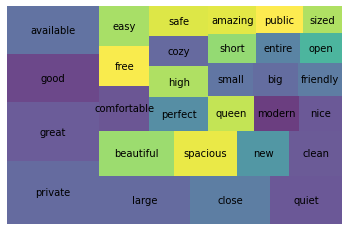

In [33]:
wc_adjs = count(df['adjs'])
wc_adjs_top20 = wc_adjs[wc_adjs['rank'] <= 30]

squarify.plot(sizes=wc_adjs_top20['pct_total'], label=wc_adjs_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

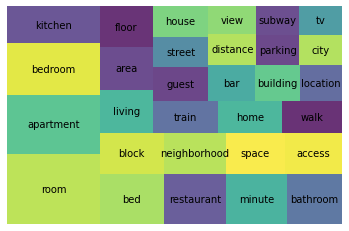

In [34]:
wc_nouns = count(df['nouns'])
wc_nouns_top20 = wc_nouns[wc_nouns['rank'] <= 30]

squarify.plot(sizes=wc_nouns_top20['pct_total'], label=wc_nouns_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [35]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

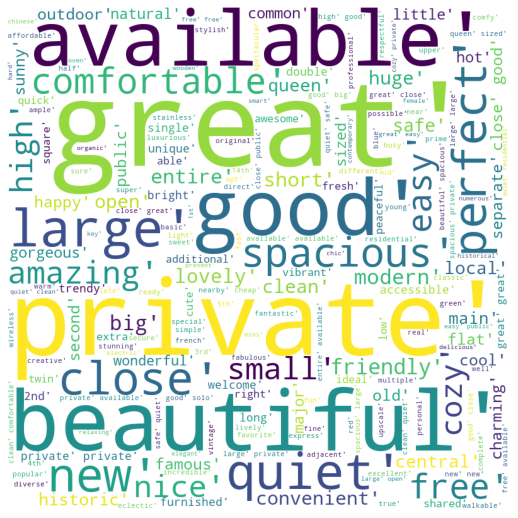

In [43]:
comment_words = '' 
stopwords = stop_words
  
# iterate through the csv file 
for val in df['adjs']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

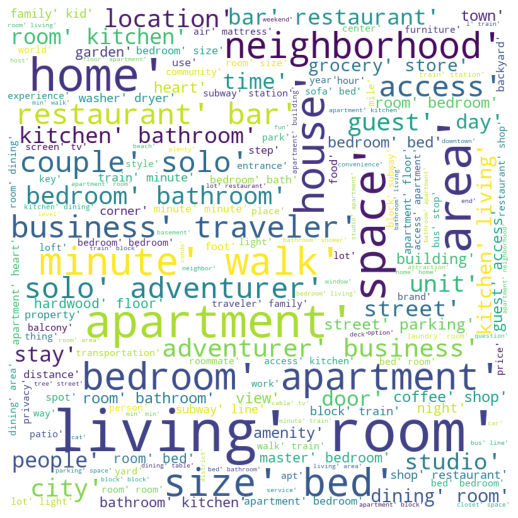

In [42]:
comment_words = '' 
stopwords = stop_words
  
# iterate through the csv file 
for val in df['nouns']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 